# Import Necessary Library

In [1]:
import time
from haversine_script import *
import numpy as np
import tensorflow as tf
import random
import pandas as p
import math
import matplotlib.pyplot as plt
import os
 


In [2]:

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Activation,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.callbacks import Callback, TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras import regularizers
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.decomposition import PCA

In [3]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 } ) 
sess = tf.compat.v1.Session(config=config) 
tf.compat.v1.keras.backend.set_session(sess)
tf.debugging.set_log_device_placement(True)

# Dataset Preprocessing Functions

In [4]:
def get_exponential_distance(x,minimum,a=60):
	positive_x= x-minimum
	numerator = np.exp(positive_x.div(a))
	denominator = np.exp(-minimum/a)
	exponential_x = numerator/denominator
	exponential_x = exponential_x * 1000  #facilitating calculations
	final_x = exponential_x
	return final_x

In [5]:
def get_powed_distance(x,minimum,b=1.1):
	positive_x= x-minimum
	numerator = positive_x.pow(b)
	denominator = (-minimum)**(b)
	powed_x = numerator/denominator
	final_x = powed_x
	return final_x

# Python Random Seeding for experiment reproducibility

In [6]:
os.environ['PYTHONHASHSEED'] = "42"
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [7]:
trial_name="MLP_withPCA=3"

In [8]:
components=3 # select the top 40 gateways 

In [9]:
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

# Loading Dataset

In [10]:
# reading the data
file = p.read_csv('lorawan_antwerp_2019_dataset.csv')
columns = file.columns
# x = file[columns[0:68]]
# y = file[columns[71:]]
x = file[columns[0:72]]
x = x.join(file[columns[73]])
y = file[columns[72:]]


Dataset Preprocessing

In [11]:
x = x.replace(-200,200)
minimum = x.min().min() - 1
x = x.replace(200,minimum)
print('minimum')
print(minimum)

minimum
-128.0


RSSI Data representation using Powed Function


In [12]:
final_x = get_powed_distance(x,minimum)

In [13]:
random_state = 42
x_train, x_test_val, y_train, y_test_val = train_test_split(final_x.values, y.values, test_size=0.3, random_state=random_state)
x_val, x_test, y_val, y_test = train_test_split(x_test_val, y_test_val, test_size=0.5, random_state=random_state)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(91300, 73)
(19564, 73)
(19565, 73)


In [14]:


scaler = preprocessing.MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


scaler_y = preprocessing.MinMaxScaler().fit(y_train)
y_train = scaler_y.transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)


PCA Application

In [15]:
pca = PCA(n_components =components) 
  
x_train = pca.fit_transform(x_train) 
x_val = pca.transform(x_val)
x_test = pca.transform(x_test)
explained_variance = pca.explained_variance_ratio_ 

In [27]:
x_train

array([[-0.12988324, -0.13157482, -0.16843161],
       [-0.3023247 , -0.32953215,  0.29987513],
       [-0.14669125, -0.22412442, -0.00707524],
       ...,
       [-0.08963255, -0.02805379, -0.2664994 ],
       [ 0.58637977,  0.06940034,  0.05362754],
       [-0.14929289,  0.00704029, -0.11213447]])

In [16]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
n_of_features = x_train.shape[1]

(91300, 3)
(19564, 3)
(19565, 3)


# Network HyperParameters

In [17]:
dropout = 0.15
l2 = 0.00
lr = 0.0005
epochs = 10000
batch_size= 512
patience = 300

# Define the MLP Network

In [18]:
#with mirrored_strategy.scope():
model = Sequential()
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=1024, input_dim=n_of_features, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=256, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout, seed=random_state))
model.add(Dense(units=128, kernel_regularizer=regularizers.l2(l2)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(dropout))
model.add(Dense(units=2))
model.compile(loss='mean_absolute_error',optimizer=Adam(lr=lr))

cb =[EarlyStopping(monitor='val_loss', patience=patience, verbose =1, restore_best_weights=True)]
history = model.fit(x_train, y_train,validation_data=(x_val, y_val),epochs=epochs, batch_size=batch_size, verbose=1, callbacks= cb)


Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Add in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Assert in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/t

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_distributed_function_3436 in device /job:localhost/replica:0/task:0/device:GPU:0
90112/91300 [============================>.] - ETA: 0s - loss: 0.1468Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_4015 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0
91300/91300 [==============================] - 20s 220us/sample - loss: 0.1459

91300/91300 [==============================] - 4s 42us/sample - loss: 0.0339 - val_loss: 0.0317
Epoch 61/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0336 - val_loss: 0.0344
Epoch 62/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0338 - val_loss: 0.0323
Epoch 63/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0338 - val_loss: 0.0326
Epoch 64/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0339 - val_loss: 0.0320
Epoch 65/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0340 - val_loss: 0.0309
Epoch 66/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0336 - val_loss: 0.0322
Epoch 67/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0334 - val_loss: 0.0312
Epoch 68/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0338 - val_loss: 0.0321
Epoch 69/10000
9

Epoch 92/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0322 - val_loss: 0.0301
Epoch 93/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0322 - val_loss: 0.0306
Epoch 94/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0319 - val_loss: 0.0308
Epoch 95/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0320 - val_loss: 0.0294
Epoch 96/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0320 - val_loss: 0.0295
Epoch 97/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0320 - val_loss: 0.0303
Epoch 98/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0316 - val_loss: 0.0298
Epoch 99/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0320 - val_loss: 0.0303
Epoch 100/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0318 - val_loss: 0.0309


91300/91300 [==============================] - 4s 42us/sample - loss: 0.0302 - val_loss: 0.0292
Epoch 155/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0301 - val_loss: 0.0276
Epoch 156/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0301 - val_loss: 0.0286
Epoch 157/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0300 - val_loss: 0.0288
Epoch 158/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0301 - val_loss: 0.0289
Epoch 159/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0301 - val_loss: 0.0287
Epoch 160/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0300 - val_loss: 0.0288
Epoch 161/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0299 - val_loss: 0.0294
Epoch 162/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0298 - val_loss: 0.0286
Epoch 16

Epoch 186/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0295 - val_loss: 0.0275
Epoch 187/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0294 - val_loss: 0.0279
Epoch 188/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0296 - val_loss: 0.0287
Epoch 189/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0296 - val_loss: 0.0286
Epoch 190/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0295 - val_loss: 0.0282
Epoch 191/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0294 - val_loss: 0.0279
Epoch 192/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0294 - val_loss: 0.0271
Epoch 193/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0293 - val_loss: 0.0277
Epoch 194/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0294 - val_loss:

91300/91300 [==============================] - 4s 40us/sample - loss: 0.0285 - val_loss: 0.0273
Epoch 249/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0285 - val_loss: 0.0269
Epoch 250/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0286 - val_loss: 0.0275
Epoch 251/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0287 - val_loss: 0.0267
Epoch 252/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0286 - val_loss: 0.0278
Epoch 253/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0286 - val_loss: 0.0270
Epoch 254/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0286 - val_loss: 0.0275
Epoch 255/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0285 - val_loss: 0.0275
Epoch 256/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0286 - val_loss: 0.0270
Epoch 25

91300/91300 [==============================] - 4s 43us/sample - loss: 0.0280 - val_loss: 0.0276
Epoch 311/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0283 - val_loss: 0.0272
Epoch 312/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0281 - val_loss: 0.0269
Epoch 313/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0281 - val_loss: 0.0268
Epoch 314/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0280 - val_loss: 0.0267
Epoch 315/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0280 - val_loss: 0.0284
Epoch 316/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0281 - val_loss: 0.0269
Epoch 317/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0280 - val_loss: 0.0279
Epoch 318/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0281 - val_loss: 0.0279
Epoch 31

91300/91300 [==============================] - 3s 37us/sample - loss: 0.0277 - val_loss: 0.0261
Epoch 373/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0276 - val_loss: 0.0268
Epoch 374/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0275 - val_loss: 0.0261
Epoch 375/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0276 - val_loss: 0.0265
Epoch 376/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0275 - val_loss: 0.0262
Epoch 377/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0276 - val_loss: 0.0268
Epoch 378/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0275 - val_loss: 0.0267
Epoch 379/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0275 - val_loss: 0.0263
Epoch 380/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0276 - val_loss: 0.0266
Epoch 38

91300/91300 [==============================] - 4s 41us/sample - loss: 0.0274 - val_loss: 0.0266
Epoch 435/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0273 - val_loss: 0.0263
Epoch 436/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0272 - val_loss: 0.0265
Epoch 437/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0272 - val_loss: 0.0263
Epoch 438/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0273 - val_loss: 0.0260
Epoch 439/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0273 - val_loss: 0.0266
Epoch 440/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0272 - val_loss: 0.0262
Epoch 441/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0272 - val_loss: 0.0259
Epoch 442/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0272 - val_loss: 0.0263
Epoch 44

Epoch 466/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0272 - val_loss: 0.0261
Epoch 467/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0271 - val_loss: 0.0270
Epoch 468/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0272 - val_loss: 0.0264
Epoch 469/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0273 - val_loss: 0.0264
Epoch 470/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0271 - val_loss: 0.0263
Epoch 471/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0270 - val_loss: 0.0260
Epoch 472/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0271 - val_loss: 0.0256
Epoch 473/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0270 - val_loss: 0.0259
Epoch 474/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0270 - val_loss:

91300/91300 [==============================] - 4s 42us/sample - loss: 0.0268 - val_loss: 0.0262
Epoch 529/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0267 - val_loss: 0.0258
Epoch 530/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0269 - val_loss: 0.0258
Epoch 531/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0267 - val_loss: 0.0259
Epoch 532/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0268 - val_loss: 0.0261
Epoch 533/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0269 - val_loss: 0.0257
Epoch 534/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0268 - val_loss: 0.0261
Epoch 535/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0269 - val_loss: 0.0259
Epoch 536/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0269 - val_loss: 0.0259
Epoch 53

Epoch 560/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0267 - val_loss: 0.0258
Epoch 561/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0267 - val_loss: 0.0256
Epoch 562/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0268 - val_loss: 0.0260
Epoch 563/10000
91300/91300 [==============================] - 4s 43us/sample - loss: 0.0267 - val_loss: 0.0258
Epoch 564/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0266 - val_loss: 0.0256
Epoch 565/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0266 - val_loss: 0.0256
Epoch 566/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0266 - val_loss: 0.0256
Epoch 567/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0266 - val_loss: 0.0261
Epoch 568/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0267 - val_loss:

91300/91300 [==============================] - 4s 43us/sample - loss: 0.0265 - val_loss: 0.0262
Epoch 623/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0265 - val_loss: 0.0262
Epoch 624/10000
91300/91300 [==============================] - 4s 40us/sample - loss: 0.0265 - val_loss: 0.0260
Epoch 625/10000
91300/91300 [==============================] - 4s 39us/sample - loss: 0.0264 - val_loss: 0.0254
Epoch 626/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0265 - val_loss: 0.0255
Epoch 627/10000
91300/91300 [==============================] - 4s 41us/sample - loss: 0.0266 - val_loss: 0.0257
Epoch 628/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0264 - val_loss: 0.0254
Epoch 629/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0264 - val_loss: 0.0255
Epoch 630/10000
91300/91300 [==============================] - 4s 42us/sample - loss: 0.0264 - val_loss: 0.0253
Epoch 63

91300/91300 [==============================] - 4s 47us/sample - loss: 0.0263 - val_loss: 0.0256
Epoch 685/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0263 - val_loss: 0.0257
Epoch 686/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0262 - val_loss: 0.0252
Epoch 687/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0264 - val_loss: 0.0257
Epoch 688/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0262 - val_loss: 0.0255
Epoch 689/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0262 - val_loss: 0.0259
Epoch 690/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0260 - val_loss: 0.0252
Epoch 691/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0263 - val_loss: 0.0255
Epoch 692/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0262 - val_loss: 0.0255
Epoch 69

91300/91300 [==============================] - 4s 47us/sample - loss: 0.0261 - val_loss: 0.0252
Epoch 747/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0260 - val_loss: 0.0255
Epoch 748/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0262 - val_loss: 0.0259
Epoch 749/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0261 - val_loss: 0.0257
Epoch 750/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0260 - val_loss: 0.0253
Epoch 751/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0261 - val_loss: 0.0252
Epoch 752/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0262 - val_loss: 0.0251
Epoch 753/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0261 - val_loss: 0.0254
Epoch 754/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0262 - val_loss: 0.0253
Epoch 75

Epoch 778/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0260 - val_loss: 0.0254
Epoch 779/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0259 - val_loss: 0.0252
Epoch 780/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0260 - val_loss: 0.0256
Epoch 781/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0260 - val_loss: 0.0254
Epoch 782/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0261 - val_loss: 0.0257
Epoch 783/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0260 - val_loss: 0.0252
Epoch 784/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0260 - val_loss: 0.0252
Epoch 785/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0260 - val_loss: 0.0253
Epoch 786/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0261 - val_loss:

91300/91300 [==============================] - 5s 50us/sample - loss: 0.0260 - val_loss: 0.0249
Epoch 841/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0260 - val_loss: 0.0254
Epoch 842/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0258 - val_loss: 0.0250
Epoch 843/10000
91300/91300 [==============================] - 5s 49us/sample - loss: 0.0259 - val_loss: 0.0250
Epoch 844/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0260 - val_loss: 0.0248
Epoch 845/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0258 - val_loss: 0.0250
Epoch 846/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0259 - val_loss: 0.0254
Epoch 847/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0259 - val_loss: 0.0253
Epoch 848/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0259 - val_loss: 0.0253
Epoch 84

Epoch 872/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0258 - val_loss: 0.0251
Epoch 873/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0259 - val_loss: 0.0247
Epoch 874/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0257 - val_loss: 0.0251
Epoch 875/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0258 - val_loss: 0.0257
Epoch 876/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0258 - val_loss: 0.0247
Epoch 877/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0258 - val_loss: 0.0256
Epoch 878/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0259 - val_loss: 0.0251
Epoch 879/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0257 - val_loss: 0.0252
Epoch 880/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0257 - val_loss:

91300/91300 [==============================] - 4s 47us/sample - loss: 0.0257 - val_loss: 0.0248
Epoch 935/10000
91300/91300 [==============================] - 5s 49us/sample - loss: 0.0257 - val_loss: 0.0252
Epoch 936/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0258 - val_loss: 0.0250
Epoch 937/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0257 - val_loss: 0.0252
Epoch 938/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0256 - val_loss: 0.0252
Epoch 939/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0257 - val_loss: 0.0258
Epoch 940/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0257 - val_loss: 0.0252
Epoch 941/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0256 - val_loss: 0.0252
Epoch 942/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0257 - val_loss: 0.0250
Epoch 94

Epoch 966/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0256 - val_loss: 0.0248
Epoch 967/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0255 - val_loss: 0.0248
Epoch 968/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0257 - val_loss: 0.0247
Epoch 969/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0256 - val_loss: 0.0249
Epoch 970/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0257 - val_loss: 0.0257
Epoch 971/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0258 - val_loss: 0.0252
Epoch 972/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0257 - val_loss: 0.0249
Epoch 973/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0256 - val_loss: 0.0255
Epoch 974/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0257 - val_loss:

91300/91300 [==============================] - 4s 48us/sample - loss: 0.0256 - val_loss: 0.0246
Epoch 1029/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0254 - val_loss: 0.0254
Epoch 1030/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0256 - val_loss: 0.0249
Epoch 1031/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0255 - val_loss: 0.0248
Epoch 1032/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0255 - val_loss: 0.0254
Epoch 1033/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0255 - val_loss: 0.0247
Epoch 1034/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0256 - val_loss: 0.0247
Epoch 1035/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0256 - val_loss: 0.0253
Epoch 1036/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0256 - val_loss: 0.0247


91300/91300 [==============================] - 4s 45us/sample - loss: 0.0255 - val_loss: 0.0250
Epoch 1091/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0254 - val_loss: 0.0246
Epoch 1092/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0254 - val_loss: 0.0251
Epoch 1093/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0254 - val_loss: 0.0251
Epoch 1094/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0253 - val_loss: 0.0249
Epoch 1095/10000
91300/91300 [==============================] - 5s 49us/sample - loss: 0.0255 - val_loss: 0.0248
Epoch 1096/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0254 - val_loss: 0.0249
Epoch 1097/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0254 - val_loss: 0.0249
Epoch 1098/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0256 - val_loss: 0.0249


91300/91300 [==============================] - 5s 50us/sample - loss: 0.0254 - val_loss: 0.0249
Epoch 1153/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0254 - val_loss: 0.0250
Epoch 1154/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0254 - val_loss: 0.0248
Epoch 1155/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0254 - val_loss: 0.0252
Epoch 1156/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0253 - val_loss: 0.0250
Epoch 1157/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0254 - val_loss: 0.0251
Epoch 1158/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0253 - val_loss: 0.0249
Epoch 1159/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0254 - val_loss: 0.0251
Epoch 1160/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0252 - val_loss: 0.0245


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0254 - val_loss: 0.0247
Epoch 1215/10000
91300/91300 [==============================] - 5s 51us/sample - loss: 0.0252 - val_loss: 0.0248
Epoch 1216/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0253 - val_loss: 0.0246
Epoch 1217/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0252 - val_loss: 0.0249
Epoch 1218/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0253 - val_loss: 0.0247
Epoch 1219/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0252 - val_loss: 0.0246
Epoch 1220/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0252 - val_loss: 0.0251
Epoch 1221/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0252 - val_loss: 0.0250
Epoch 1222/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0252 - val_loss: 0.0250


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0252 - val_loss: 0.0247
Epoch 1277/10000
91300/91300 [==============================] - 5s 49us/sample - loss: 0.0251 - val_loss: 0.0244
Epoch 1278/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0251 - val_loss: 0.0246
Epoch 1279/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0252 - val_loss: 0.0247
Epoch 1280/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0251 - val_loss: 0.0244
Epoch 1281/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0252 - val_loss: 0.0246
Epoch 1282/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0251 - val_loss: 0.0247
Epoch 1283/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0251 - val_loss: 0.0246
Epoch 1284/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0251 - val_loss: 0.0248


91300/91300 [==============================] - 4s 49us/sample - loss: 0.0251 - val_loss: 0.0247
Epoch 1339/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0251 - val_loss: 0.0247
Epoch 1340/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0251 - val_loss: 0.0247
Epoch 1341/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0250 - val_loss: 0.0243
Epoch 1342/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0250 - val_loss: 0.0249
Epoch 1343/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0250 - val_loss: 0.0251
Epoch 1344/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0251 - val_loss: 0.0248
Epoch 1345/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0251 - val_loss: 0.0245
Epoch 1346/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0250 - val_loss: 0.0244


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0250 - val_loss: 0.0246
Epoch 1401/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0250 - val_loss: 0.0247
Epoch 1402/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0250 - val_loss: 0.0248
Epoch 1403/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0250 - val_loss: 0.0246
Epoch 1404/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0250 - val_loss: 0.0247
Epoch 1405/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0249 - val_loss: 0.0245
Epoch 1406/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0250 - val_loss: 0.0247
Epoch 1407/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0251 - val_loss: 0.0246
Epoch 1408/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0249 - val_loss: 0.0248


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0250 - val_loss: 0.0246
Epoch 1463/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0249 - val_loss: 0.0244
Epoch 1464/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0248 - val_loss: 0.0243
Epoch 1465/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0249 - val_loss: 0.0244
Epoch 1466/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0249 - val_loss: 0.0244
Epoch 1467/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0249 - val_loss: 0.0245
Epoch 1468/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0250 - val_loss: 0.0243
Epoch 1469/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0250 - val_loss: 0.0245
Epoch 1470/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0250 - val_loss: 0.0245


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0249 - val_loss: 0.0244
Epoch 1525/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0249 - val_loss: 0.0244
Epoch 1526/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0249 - val_loss: 0.0243
Epoch 1527/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0249 - val_loss: 0.0248
Epoch 1528/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0247 - val_loss: 0.0245
Epoch 1529/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0249 - val_loss: 0.0245
Epoch 1530/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0249 - val_loss: 0.0246
Epoch 1531/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0248 - val_loss: 0.0246
Epoch 1532/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0249 - val_loss: 0.0244


91300/91300 [==============================] - 4s 46us/sample - loss: 0.0249 - val_loss: 0.0244
Epoch 1587/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0248 - val_loss: 0.0245
Epoch 1588/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0248 - val_loss: 0.0243
Epoch 1589/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0247 - val_loss: 0.0248
Epoch 1590/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0249 - val_loss: 0.0244
Epoch 1591/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0247 - val_loss: 0.0250
Epoch 1592/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0247 - val_loss: 0.0244
Epoch 1593/10000
91300/91300 [==============================] - 4s 44us/sample - loss: 0.0247 - val_loss: 0.0247
Epoch 1594/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0248 - val_loss: 0.0245


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0246 - val_loss: 0.0244
Epoch 1649/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0247 - val_loss: 0.0246
Epoch 1650/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0249 - val_loss: 0.0248
Epoch 1651/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0249 - val_loss: 0.0245
Epoch 1652/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0247 - val_loss: 0.0251
Epoch 1653/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0247 - val_loss: 0.0249
Epoch 1654/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0248 - val_loss: 0.0242
Epoch 1655/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0247 - val_loss: 0.0249
Epoch 1656/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0248 - val_loss: 0.0246


91300/91300 [==============================] - 4s 49us/sample - loss: 0.0246 - val_loss: 0.0244
Epoch 1711/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0247 - val_loss: 0.0242
Epoch 1712/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0247 - val_loss: 0.0247
Epoch 1713/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0246 - val_loss: 0.0241
Epoch 1714/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0246 - val_loss: 0.0245
Epoch 1715/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0249 - val_loss: 0.0245
Epoch 1716/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0248 - val_loss: 0.0246
Epoch 1717/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0247 - val_loss: 0.0242
Epoch 1718/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0247 - val_loss: 0.0247


91300/91300 [==============================] - 4s 47us/sample - loss: 0.0246 - val_loss: 0.0247
Epoch 1773/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0246 - val_loss: 0.0244
Epoch 1774/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0247 - val_loss: 0.0245
Epoch 1775/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0247 - val_loss: 0.0244
Epoch 1776/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0246 - val_loss: 0.0244
Epoch 1777/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0247 - val_loss: 0.0246
Epoch 1778/10000
91300/91300 [==============================] - 5s 49us/sample - loss: 0.0246 - val_loss: 0.0244
Epoch 1779/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0247 - val_loss: 0.0247
Epoch 1780/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0246 - val_loss: 0.0245


91300/91300 [==============================] - 4s 49us/sample - loss: 0.0246 - val_loss: 0.0244
Epoch 1835/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0246 - val_loss: 0.0246
Epoch 1836/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0246 - val_loss: 0.0243
Epoch 1837/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0246 - val_loss: 0.0244
Epoch 1838/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0246 - val_loss: 0.0244
Epoch 1839/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0246 - val_loss: 0.0246
Epoch 1840/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0245 - val_loss: 0.0246
Epoch 1841/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0246 - val_loss: 0.0247
Epoch 1842/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0246 - val_loss: 0.0242


91300/91300 [==============================] - 4s 48us/sample - loss: 0.0245 - val_loss: 0.0243
Epoch 1897/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0245 - val_loss: 0.0246
Epoch 1898/10000
91300/91300 [==============================] - 4s 45us/sample - loss: 0.0245 - val_loss: 0.0245
Epoch 1899/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0245 - val_loss: 0.0244
Epoch 1900/10000
91300/91300 [==============================] - 5s 50us/sample - loss: 0.0246 - val_loss: 0.0242
Epoch 1901/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0246 - val_loss: 0.0245
Epoch 1902/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0244 - val_loss: 0.0244
Epoch 1903/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0245 - val_loss: 0.0243
Epoch 1904/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0244 - val_loss: 0.0245


91300/91300 [==============================] - 4s 49us/sample - loss: 0.0244 - val_loss: 0.0244
Epoch 1959/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0244 - val_loss: 0.0241
Epoch 1960/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0245 - val_loss: 0.0242
Epoch 1961/10000
91300/91300 [==============================] - 4s 47us/sample - loss: 0.0245 - val_loss: 0.0243
Epoch 1962/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0245 - val_loss: 0.0245
Epoch 1963/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0245 - val_loss: 0.0245
Epoch 1964/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0243 - val_loss: 0.0245
Epoch 1965/10000
91300/91300 [==============================] - 4s 46us/sample - loss: 0.0245 - val_loss: 0.0246
Epoch 1966/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0245 - val_loss: 0.0244


91300/91300 [==============================] - 4s 46us/sample - loss: 0.0245 - val_loss: 0.0245
Epoch 2021/10000
91300/91300 [==============================] - 5s 49us/sample - loss: 0.0245 - val_loss: 0.0243
Epoch 2022/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0244 - val_loss: 0.0243
Epoch 2023/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0244 - val_loss: 0.0247
Epoch 2024/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0244 - val_loss: 0.0243
Epoch 2025/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0244 - val_loss: 0.0242
Epoch 2026/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0245 - val_loss: 0.0242
Epoch 2027/10000
91300/91300 [==============================] - 4s 49us/sample - loss: 0.0244 - val_loss: 0.0242
Epoch 2028/10000
91300/91300 [==============================] - 4s 48us/sample - loss: 0.0245 - val_loss: 0.0243


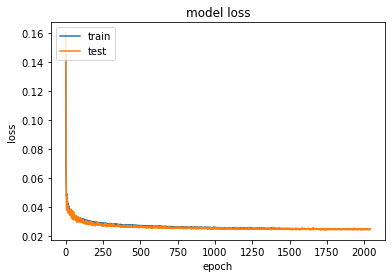

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('training_curves.png')
plt.show()

# Testing

In [20]:
y_predict = model.predict(x_test, batch_size=batch_size) 
y_predict_in_val = model.predict(x_val, batch_size=batch_size)
y_predict_in_train = model.predict(x_train, batch_size=batch_size)


Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AnonymousIteratorV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op __inference_distributed_function_904342 in device /job:localhost/replica:0/task

Revert the Representation from normalize to lat-long coordinates

In [21]:
y_predict = scaler_y.inverse_transform(y_predict)
y_predict_in_train = scaler_y.inverse_transform(y_predict_in_train)
y_predict_in_val = scaler_y.inverse_transform(y_predict_in_val)
y_train = scaler_y.inverse_transform(y_train)
y_val = scaler_y.inverse_transform(y_val)
y_test = scaler_y.inverse_transform(y_test)

Calculate Haversine Error

In [22]:
print("Train set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'mean')))
print("Train set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'median')))
print("Train set75th perc error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_train, y_train,'percentile',75)))
print("Val set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'mean')))
print("Val set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'median')))
print("Val set 75th perc.  error: {:.2f}".format(my_custom_haversine_error_stats(y_predict_in_val, y_val,'percentile',75)))
print("Test set mean error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'mean')))
print("Test set median error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'median')))
print("Test set  75th perc. error: {:.2f}".format(my_custom_haversine_error_stats(y_predict, y_test,'percentile',75)))


Train set mean error: 233.67
Train set median error: 92.78
Train set75th perc error: 305.95
Val set mean error: 256.68
Val set median error: 102.57
Val set 75th perc.  error: 344.41
Test set mean error: 255.48
Test set median error: 101.11
Test set  75th perc. error: 338.67


In [23]:
test_error_list = calculate_pairwise_error_list(y_predict,y_test)
p.DataFrame(test_error_list).to_csv(trial_name+".csv")
print("Experiment completed!!!")

Experiment completed!!!


In [31]:
# keras library import  for Saving and loading model and weights

from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model



In [32]:
# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = model.to_json()


with open(trial_name+".json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(trial_name+".h5")